In [8]:
import os
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.models import Sequential
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report

In [9]:
batch_size = 32
dataset_code = 'A_augmented'
model_name = 'VGG-16'
data_saved_dir = r'D:\My Code\Classification\pickle_data'
model_saved_dir = r'D:\My Code\Classification\models'
train_data_path = f'{data_saved_dir}\A_augmented_training.pkl'
val_data_path = f'{data_saved_dir}\A_validation.pkl'
test_data_path = f'{data_saved_dir}\A_testing.pkl'

In [10]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

train_images, train_labels = load_pickle(train_data_path)
val_images, val_labels = load_pickle(val_data_path)
test_images, test_labels = load_pickle(test_data_path)

print(f'Training images: {train_images.shape}')
print(f'Validation images: {val_images.shape}')
print(f'Testing images: {test_images.shape}')

Training images: (6345, 256, 256, 3)
Validation images: (838, 256, 256, 3)
Testing images: (845, 256, 256, 3)


In [11]:
class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_images = self.images[start:end]
        batch_labels = self.labels[start:end]
        return batch_images, batch_labels

train_data_generator = CustomDataGenerator(train_images, train_labels, batch_size)
val_data_generator = CustomDataGenerator(val_images, val_labels, batch_size)
test_data_generator = CustomDataGenerator(test_images, test_labels, batch_size)

In [12]:
Vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
model = Sequential()
model.add(Vgg16)

for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(units=2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 2048)              67110912  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 81,827,649
Trainable params: 67,112,961
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model_dir = f'{model_saved_dir}\{dataset_code}_{model_name}'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
else:
    print(f'{model_dir} already exists')

filename = 'weights-improvement-{epoch:02d}-{val_accuracy:.2f}'
filepath = f'{model_dir}\{dataset_code}_{model_name}-{filename}.hdf5'
 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

callbacks_list = [checkpoint, early_stop]

In [14]:
history = model.fit(train_data_generator, epochs=50, validation_data=val_data_generator, callbacks = callbacks_list)

Epoch 1/50
199/199 [==============================] - ETA: 0s - loss: 0.8287 - accuracy: 0.8652
Epoch 1: val_accuracy improved from -inf to 0.92243, saving model to D:\My Code\Classification\models\A_augmented_VGG-16\A_augmented_VGG-16-weights-improvement-01-0.92.hdf5
199/199 [==============================] - 36s 178ms/step - loss: 0.8287 - accuracy: 0.8652 - val_loss: 0.1836 - val_accuracy: 0.9224
Epoch 2/50
199/199 [==============================] - ETA: 0s - loss: 0.1348 - accuracy: 0.9461
Epoch 2: val_accuracy did not improve from 0.92243
199/199 [==============================] - 26s 127ms/step - loss: 0.1348 - accuracy: 0.9461 - val_loss: 0.2830 - val_accuracy: 0.9177
Epoch 3/50
199/199 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.9587
Epoch 3: val_accuracy improved from 0.92243 to 0.92601, saving model to D:\My Code\Classification\models\A_augmented_VGG-16\A_augmented_VGG-16-weights-improvement-03-0.93.hdf5
199/199 [==============================] - 3

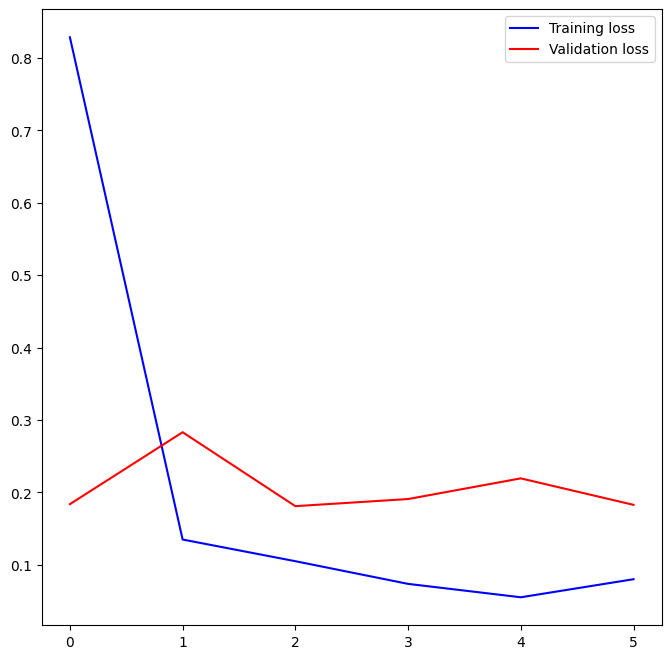

<Figure size 640x480 with 0 Axes>

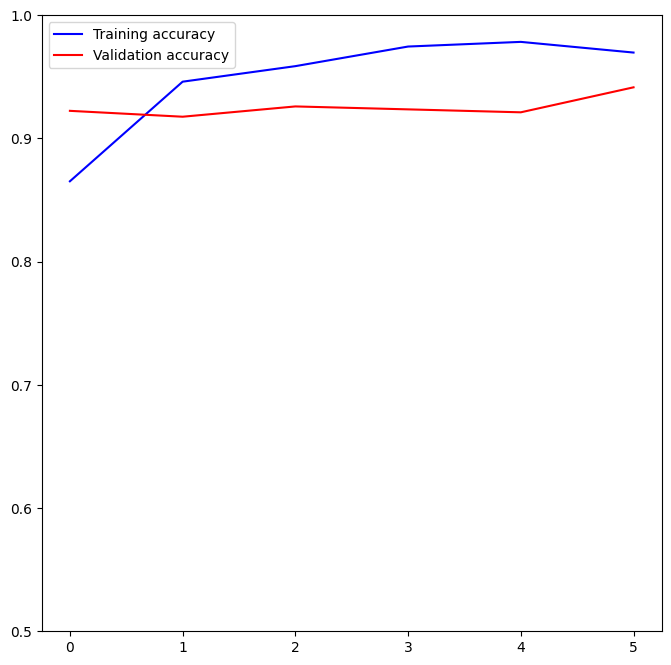

In [15]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.ylim(0.5, 1)
plt.show()

#### Testing on model till Last Epoch

27/27 [==============================] - 4s 141ms/step


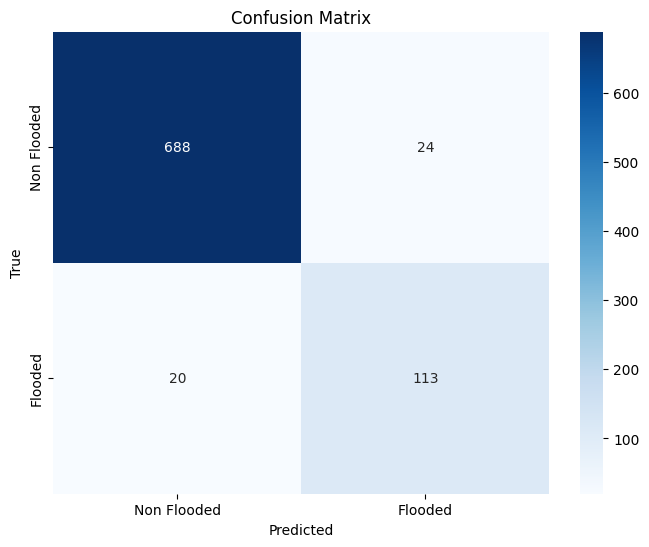

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       712
           1       0.82      0.85      0.84       133

    accuracy                           0.95       845
   macro avg       0.90      0.91      0.90       845
weighted avg       0.95      0.95      0.95       845



In [16]:
predictions = model.predict(test_data_generator)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

#### Testing on model which is last best saved

Best model loaded ...
27/27 [==============================] - 3s 107ms/step


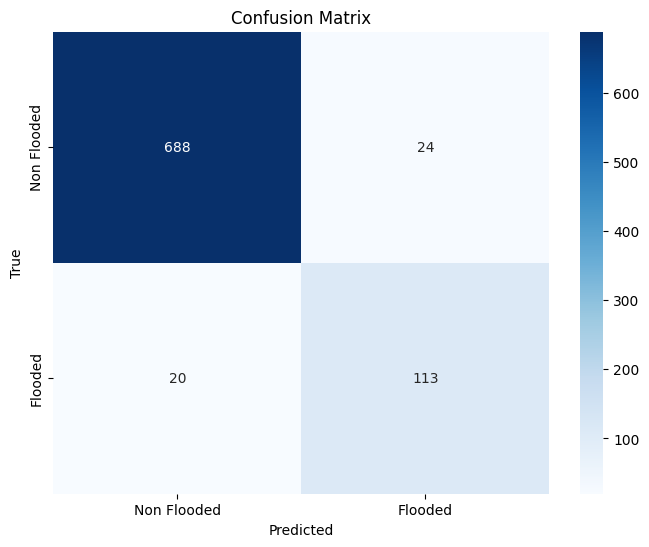

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       712
           1       0.82      0.85      0.84       133

    accuracy                           0.95       845
   macro avg       0.90      0.91      0.90       845
weighted avg       0.95      0.95      0.95       845



In [17]:
from keras.models import load_model

models = sorted(os.listdir(model_dir))

for file in models[:-1]:
    os.remove(f'{model_dir}\{file}')

best_model = load_model(f'{model_dir}\{models[-1]}')
print('Best model loaded ...')

predictions = best_model.predict(test_data_generator)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))